In [4]:
import numpy as np
import matplotlib.pyplot as plt

Hidden Markov Models
---------------------------

Below we implement a Kalman filter with:

$$
y_t = \sin(\omega t) + \sigma^2\epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, 1)
$$

Recall, that a Kalman filtering is just using an latent AR(1) model that has the following components:

 - Initial density: $ p( \mathbf{x}_1 \mid \theta ) = \mathcal{N}(\mathbf{x}_1; \mu_1, \Sigma_1) $
 - Transition density: $ p( \mathbf{x}_n \mid \mathbf{x}_{n - 1}, \theta ) = \mathcal{N}(\mathbf{x}_n; A\mathbf{x}_{n-1}, Q) $
 - Emission density: $ p( \mathbf{y}_n \mid \mathbf{x}_{n}) = \mathcal{N}(\mathbf{y}_n; C\mathbf{x}_{n}, R) $

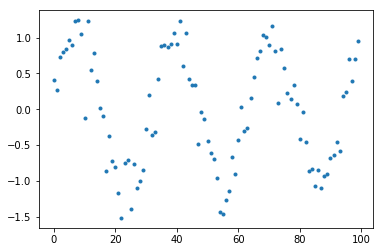

In [5]:
# Define y_t
def y(t, omega, var):
    noise = np.random.normal(0, var)
    return np.sin(omega * t) + noise

# Generate some data
data = [y(t, 0.2, 0.3) for t in range(100)]

plt.plot(data, marker='.', linestyle='none');

## Discrete HMMs

Assume we have observations $x_{1:T} = \{x_1, x_2, ..., x_T \}$.
For discrete HMMs, the fundamental assumptions are:
- Time is discrete (i.e. there are discrete states $s_1, s_2, ...$) and at each timestep $t$ a hidden state $s_t$ generated the observation $x_t$.
- There are finite number of states $N$ (represented by integers 1 to $N$)
- There are a finitie number of possible emissions $K$ (represented by integers 1 to $K$)
- Factorisation assumption:
$$
    p(x_{1:T}, z_{1:T}) = p(z_1)p(x_1 \mid z_1) \prod_{t=1}^T p(z_t \mid z_{t-1})p(x_t \mid z_t)
$$

The usual components of the HMM are as follows:
- Initial probabilities: $\pi_n = p(z_1 = n)$
- Transition probabilities: $T_{i, j} = p(z_t = i \mid z_{t-1} = j)$
- Emission probabilities: $ E_{n, k} = p(x_t = k \mid z_t = n)$

With the obvious constraints:
- $\sum_{n = 1}^N \pi_n = 1$
- $\forall i \in \{1,...,N\}:\quad \sum_{n = 1}^N T_{i, n} = 1$
- $\forall n \in \{1,...,N\}:\quad \sum_{k = 1}^K E_{n, k} = 1$ 

Given some data, we might wish to infer the values $\theta = \{\pi, T, E\}$.

This can be done using the EM algorithm. The flavour presented below is also called the Baum-Welch algorithm.

### The E-step

The E-step of Baum-Welch is also referred to as the Forward-Backward algorithm, and it works as follows:

__The big picture:__ We want to calculate the posterior of the latent variables for fixed $\theta$: $p(z_t \mid x_{1:N}, \theta) \propto p(z_t, x_{1:N} \mid \theta)$.

We wish to calculate: $p(z_t, x_{1:N} \mid \theta)$ for every $z_t$. We can split this up as follows:

$$
p(z_t, x_{1:N} \mid \theta) = p(z_t, x_{1:t} \mid \theta)p(x_{t+1:N} \mid z_t, x_{1:t}, \theta) = p(z_t, x_{1:t} \mid \theta)\underbrace{p(x_{t+1:N} \mid z_t, \theta)}_{\text{since } x_{t+1:N} \text{ are cond. indep. of } x_{1:t} \text{ given } z_t}
$$

We will calculate the first term on the LHS using the forward part of the algorithm, and the second part by the backward algorithm.

#### Forward Algorithm

Consider first $p(z_t, x_{1:t} \mid \theta)$:

$$
\begin{align*}
\alpha_t(s) = p(z_t = s, x_{1:t} \mid \theta) 
& = p(x_t = k \mid z_t = s, x_{1:t - 1}, \theta)p(z_t = s\mid x_{1: t - 1}, \theta)\\ 
& = \underbrace{p(x_t = k\mid z_t = s, \theta)}_{\text{since } x_{t} \text{ is cond. indep. of } x_{1:t-1} \text{ given } z_t}p(z_t = s\mid x_{1: t - 1}, \theta)\\ 
& = p(x_t = k\mid z_t = s, \theta) \sum_{n = 1}^N p(z_t = s, z_{t - 1} = n \mid x_{1:t-1}, \theta)\\ 
& = \underbrace{p(x_t = k\mid z_t = s, \theta)}_{E_{s, k}} \sum_{n = 1}^N \underbrace{p(z_t = s \mid  z_{t - 1} = n, \theta)}_{T_{s, n}} \underbrace{p(z_{t - 1} = n \mid x_{1:t-1}, \theta)}_{\alpha_{t - 1}(n)}\\ 
& = E_{s, k} \sum_{n = 1}^N T_{s, n}\alpha_{t - 1}(n)
\end{align*}
$$

Hence we have obtained the recursive relationship:

$$
\alpha_t(s) = E_{s, k} \sum_{n = 1}^N T_{s, n}\alpha_{t - 1}(n)
$$

for $t \geq 2$. For $t = 1$, we have:
$$
\alpha_1(s) = p(z_1 = s, x_1 = k) = p(x_1 = k \mid z_1 = s)p(z_1 = s) = E_{s, k}\pi_s
$$

In vectorised form, let $\alpha_t = [\alpha_t(1), \alpha_t(2), ..., \alpha_t(N)]^T$. Then, we have:

$$
\alpha_t = \overbrace{E_{\cdot, k}}^{N \times 1} \odot \overbrace{ \underbrace{T}_{N \times N} \underbrace{\alpha_{t - 1}^T}_{N\times 1}}^{N \times 1}
$$

where $\odot$ is elementwise multiplication.

#### Backward Algorithm

Now, consider $p(x_{t+1:T} \mid z_t, \theta)$:

$$
\begin{align*}
\beta_t(s) = p(x_{t+1:T} \mid z_t = s, \theta) & = \sum_{n = 1}^N p(x_{t+1:T}, z_{t + 1} = n\mid z_t = s, \theta) \\
& = \sum_{n = 1}^N p(x_{t+2:T}\mid z_{t + 1} = n, x_{t + 1} = k, z_t = s, \theta)p(x_{t + 1} = k \mid z_{t + 1} = n, z_t = s, \theta)p(z_{t + 1} = n \mid z_t = s, \theta) \\
& = \sum_{n = 1}^N \underbrace{p(x_{t+2:T}\mid z_{t + 1} = n, \theta)}_{\text{cond. indep.}}\underbrace{p(x_{t + 1} = k \mid z_{t + 1} = n, \theta)}_{\text{cond. indep.}}p(z_{t + 1} = n \mid z_t = s, \theta) \\
& = \sum_{n = 1}^N \beta_{t + 1}(n)E_{n, k}T_{n, s}
\end{align*}
$$

Hence we have obtained the recursive relationship:

$$
\beta(s) = \sum_{n = 1}^N \beta_{t + 1}(n)E_{n, k}T_{n, s}
$$

for $t \leq T - 1$. For $t = T$ we have:
$$
\begin{align*}
\beta_{T - 1}(s) & = \sum_{n = 1}^N p(x_T, z_T = n\mid z_{T - 1} = s, \theta) \\
& = \sum_{n = 1}^N p(x_T \mid z_T = n, \theta)p(z_T = n \mid z_{T - 1} = s, \theta) \\
& = \sum_{n = 1}^N E_{n, k}T_{n, s} = \sum_{n = 1}^N \beta_{T}(n)E_{n, k}T_{n, s}.
\end{align*}
$$
For the last equality to hold, we must have $\beta_T(s) = 1$ for every $s$.

In [44]:
# Input data
xs = "AASDFAGASDGSADGDSGFAGAFSDGASGFASGDFAGDFGASDGASFDGASFDGASFDGFASGDFASGDFAGSFDGASDGFASFSGAGAFSGDGFAGFSGFDFDFDGAGSFDFDFAGAGSFDGF"

# Define the parameters of the HMM
num_states = 3
num_symbols = 25

# Dummy names for later
N = num_states
K = num_symbols
L = len(xs)

# Components of the HMM
pi = np.random.rand(N,1).ravel()
T = np.random.rand(N, N)
E = np.random.rand(N, K)

# Enforce the 3 probability constraints
pi = pi/np.sum(pi)
               
T_norm = np.sum(T, axis=1)
for n in range(N):
    T[n, :] = T[n, :]/T_norm[n]

E_norm = np.sum(E, axis=0)
for k in range(K):
    E[:, k] = E[:, k]/E_norm[k]
    
# Transform the input data to states
xs_s = list(map(lambda x: ord(x) - ord('A'), xs))     

log_alphas = np.ndarray((L, N))
log_betas = np.ndarray((L, N))

log_pi = np.log(pi)
log_T = np.log(T)
log_E = np.log(E)

# Set the base cases for alphas and betas
log_alphas[0, :] = np.log(E[:, xs_s[0]]) + log_pi
log_betas[0, :] = np.zeros((1, N))

# Function for the log-sum-exp trick
# log(alpha_t(n)) = log(E_{n, x_t}) + b + log(sum_{n = 1}^N exp(a_n - b))
def log_sum_exp(terms):
    if len(terms) == 0: return 0
    
    b = np.max(terms)
    ts = terms - b
    
    return b + np.log(np.sum(np.exp(ts)))

# Calculate the rest of the alphas based on the formula
for t in range(1, L):
    for n in range(N):
        a = log_T[n, :] + log_alphas[t - 1, :]
        
        log_alphas[t, n] = log_E[n, xs_s[t]] + log_sum_exp(a)

# Calculate the betas
for t in range(1, L):
    for n in range(N):
        a = log_E[:, xs_s[t]] + log_T[:, n] + log_betas[t - 1, :]

        log_betas[t, n] = log_sum_exp(a)
        
# We calculated stuff backwards, so flip along time axis
log_betas = np.flip(log_betas, axis=0)

### The M-step

$\newcommand{\diff}[2]{\frac{\partial #1}{\partial #2}}$

__The big picture:__ Given the posterior, we want to calculate the maximum likelihood estimate for $\theta$.

We want to maximise the log-likelihood, however, it is easier to maximise the expected value of the joint w.r.t. the posterior $q(z_{1:T}) = p(z_{1:T} \mid x_{1:T}, \theta)$, which can be show to be equivalent:
$$
\begin{align*}
L'(\theta) &= \mathbb{E}_{q}[\log p(z_{1:T}, x_{1:T})] \\
&= \mathbb{E}_{q}\left[ \log \left\{ p(z_1)p(x_1 \mid z_1) \prod_{t=2}^T p(z_t\mid z_{t-1})p(x_t\mid z_t)\right\} \right ]\quad\text{by the Factorisation Assumption} \\
&=\mathbb{E}_{q}\left[ \log p(z_1) + \log \left\{ \prod_{t=1}^T p(x_t \mid z_t)\right\} + \log\left\{\prod_{t=2}^T p(z_t\mid z_{t-1})\right\} \right ] \\
&=\mathbb{E}_{q}\left[ \log p(z_1) + \sum_{t=1}^T \log p(x_t \mid z_t) + \sum_{t=2}^T\log p(z_t\mid z_{t-1})\right ] \\
&=\mathbb{E}_{q(z_1)}\left[ \log p(z_1) \right] + \sum_{t=1}^T \mathbb{E}_{q(z_t)}\left[\log p(x_t \mid z_t)\right] + \sum_{t=2}^T \mathbb{E}_{q(z_t, z_{t-1})}\left[\log p(z_t\mid z_{t-1})\right ] \quad\text{by the linearity of } \mathbb{E}[\cdot]\\
&=\sum_{n=1}^N q(z_1 = n)\log p(z_1 = n) + \sum_{t=1}^T \sum_{n=1}^N q(z_t=n)\log p(x_t \mid z_t = n) \\ & \quad\quad + \sum_{t=2}^T \sum_{n=1}^N\sum_{m=1}^M q(z_t = n \mid z_{t-1} = m) \log p(z_t = n\mid z_{t-1} = m) \\
&=\sum_{n=1}^N q(z_1 = n)\log\pi_n + \sum_{t=1}^T \sum_{n=1}^N q(z_t=n)\log E_{n,x_t} + \sum_{t=2}^T \sum_{n=1}^N\sum_{m=1}^N q(z_t = n , z_{t-1} = m) \log T_{n, m} \\
\end{align*}
$$

However, we cannot maximise $L'(\theta)$ just yet, as it does not incorporate the 3 probability assumptions. We therefore define a new function $L(\theta)$ which does incorporate them using Lagrange multipliers:

$$
L(\theta) = L'(\theta) + \alpha \underbrace{\left [ \sum_{n = 1}^N \pi_n - 1 \right]}_{\pi \text{ is a pmf}} + \beta \underbrace{\left [ \sum_{n=1}^N \sum_{k=1}^K  E_{n,k} - N \right ]}_{\text{each row $E$ of is a pmf}} + \gamma \underbrace{\left [ \sum_{n=1}^N \sum_{m=1}^N  T_{n,m} - N \right ]}_{\text{each column $T$ of is a pmf}}
$$

This can now be differentiated w.r.t. $\pi, E$ and $T$. 

First we take care of $\pi$:

$$
\diff{L(\theta)}{\pi_s} = \frac{q(z_1 = s)}{\pi_s} + \alpha = 0 \quad\Rightarrow\quad \pi_s = -\frac{q(z_1 = s)}{\alpha}
$$
Then, since $\sum_{n = 1}^N \pi_n = 1$, we have

$$
\sum_{n = 1}^N \pi_s = -\frac{1}{\alpha}\sum_{n = 1}^N q(z_1 = n) = 1 \quad\Rightarrow\quad -\sum_{n = 1}^N q(z_1 = n) = \alpha
$$

Substituting this back, we get:
$$
    \pi_s = \frac{q(z_1 = s)}{\sum_{n = 1}^N q(z_1 = n)}
$$

Next, we take care of $E$:

$$
\begin{align*}
\diff{L(\theta)}{E_{n', k'}} &= \beta + \diff{}{E_{n', k'}}\sum_{t=1}^T \sum_{n=1}^N q(z_t=n)\log E_{n,x_t}\\
& = \beta + \sum_{t=1}^T \delta(x_t = k') \frac{q(z_t=n')}{E_{n',k'}} = 0 \quad \text{where $\delta$ is the Kronecker delta}\\
\end{align*}
$$
Whence
$$
E_{n', k'} = -\frac{1}{\beta}\sum_{t=1}^T \delta(x_t = k') q(z_t=n')
$$

Now, using the constraint that $\forall n: \sum_{k=1}^K  E_{n,k} = 1 $:

$$
     \sum_{k=1}^K  -\frac{1}{\beta}\sum_{t=1}^T \delta(x_t = k) q(z_t=n) = N \quad \Rightarrow \quad \beta = -\sum_{t=1}^T \underbrace{\sum_{k=1}^K\delta(x_t = k)}_{x_t = k \text{ is true for one and only one } k} q(z_t=n) = -\sum_{t=1}^T q(z_t=n) 
$$

Therefore, we have:
$$
    E_{n, k} = \frac{\sum_{t=1}^T \delta(x_t = k) q(z_t=n)}{\sum_{t=1}^T q(z_t=n)} \\
$$

Finally, we take care of $T$:

$$
    \diff{L(\theta)}{T_{n', m'}} = \gamma + \sum_{t=2}^T \frac{q(z_t = n', z_{t-1} = m')}{T_{n', m'}} = 0 \quad \Rightarrow\quad T_{n', m'} = - \frac{1}{\gamma}\sum_{t=2}^T q(z_t = n', z_{t-1} = m')
$$

Using the constraint that $\forall m: \sum_{n=1}^N T_{n,m} = 1$:

$$
\begin{align*}
&\sum_{n=1}^N - \frac{1}{\gamma}\sum_{t=2}^T q(z_t = n, z_{t-1} = m) = N \\ \\
\Rightarrow\quad 
\gamma &= - \sum_{n=1}^N \sum_{t=2}^T q(z_t = n, z_{t-1} = m) \\
 &= - \sum_{t=2}^T \sum_{n=1}^N q(z_t = n\mid z_{t-1} = m)q(z_{t-1} = m) \quad \text{reorder summation}\\
&= - \sum_{t=2}^T \sum_{n=1}^N  T_{n, m}q(z_{t-1} = m) \\
&= - \sum_{t=2}^T q(z_{t-1} = m)\underbrace{\sum_{n=1}^N T_{n, m}}_{\text{Every column sums to 1}} \\
&= - \sum_{t=2}^T q(z_{t-1} = m)= - \sum_{t=1}^{T-1} q(z_{t} = m) \\
\end{align*}
$$
And hence:

$$
T_{n, m} = \frac{\sum_{t=2}^T q(z_t = n, z_{t-1} = m)}{\sum_{t=1}^{T-1} q(z_{t} = m)}
$$

Finally, we note that we have
$$
q(z_t = n) = p(z_t = n \mid x_{1:T}, \theta) = \frac{p(z_t = n, x_{1:T} \mid \theta)}{p(x_{1:T})} = \frac{\alpha_t(n)\beta_t(n)}{\sum_{m=1}^N\alpha_t(m)\beta_t(m)}
$$
and
$$
\begin{align*}
q(z_t = n, z_{t-1} = m) &= p(z_t = n, z_{t-1} = m \mid x_{1:T}, \theta) \\
&= \frac{p(z_t = n, z_{t-1} = m, x_{1:T}\mid \theta)}{p(x_{1:T})} \\
&= \frac{p(z_t = n, z_{t-1} = m, x_{1:t - 1}, x_t, x_{t+1:T}\mid \theta)}{p(x_{1:T})} \\
&= \frac{p(x_t \mid z_t = n, \theta)p(z_t = n, z_{t-1} = m, x_{1:t - 1}, x_{t+1:T}\mid \theta)}{p(x_{1:T})} \\
&= \frac{E_{n, x_t}p(x_{t+1:T}\mid z_t = n, \theta)p(z_t = n, z_{t-1} = m, x_{1:t - 1}\mid \theta)}{p(x_{1:T})} \\
&= \frac{E_{n, x_t}\beta_t(n)p(z_t = n \mid z_{t-1} = m, \theta)p(z_{t-1} = m, x_{1:t - 1}\mid \theta)}{p(x_{1:T})} \\
&= \frac{E_{n, x_t}\beta_t(n)T_{n, m}\alpha_{t-1}(m)}{p(x_{1:T})} \\
&= \frac{E_{n, x_t}\beta_t(n)T_{n, m}\alpha_{t-1}(m)}{\sum_{n'=1}^N\sum_{m'=1}^N E_{n', x_t}\beta_t(n')T_{n', m'}\alpha_{t-1}(m')} \\
\end{align*}
$$

### Summary

We need to implement the following update rules:

$$
\begin{align*}
    \pi_s &= \frac{q(z_1 = s)}{\sum_{n = 1}^N q(z_1 = n)} \\ \\
    E_{n, k} &= \frac{\sum_{t=1}^T \delta(x_t = k) q(z_t=n)}{\sum_{t=1}^T q(z_t=n)} \\ \\
    T_{n, m} &= \frac{\sum_{t=2}^T q(z_t = n, z_{t-1} = m)}{\sum_{t=1}^{T-1} q(z_{t} = m)}
\end{align*}
$$

Where $q$ is calculated as:
$$
\begin{align*}
q(z_t = n) &= \frac{\alpha_t(n)\beta_t(n)}{\sum_{m=1}^N\alpha_t(m)\beta_t(m)} \\ \\
q(z_t = n, z_{t-1} = m) &= \frac{E_{n, x_t}\beta_t(n)T_{n, m}\alpha_{t-1}(m)}{\sum_{n'=1}^N\sum_{m'=1}^N E_{n', x_t}\beta_t(n')T_{n', m'}\alpha_{t-1}(m')} 
\end{align*}
$$

Given these three update rules, we can now perform the M-step:

In [45]:
# Calculate Qs

log_uni = np.ndarray((L, N))
    
for t in range(L):
    for n in range(N):
        log_uni[t, n] = log_alphas[t, n] + log_betas[t, n]
        
    log_uni[t, :] -= log_sum_exp(log_uni[t, :])

log_joint = np.ndarray((L-1, N, N))
for t in range(1, L):
    for n in range(N):
        for m in range(N):
            log_joint[t - 1, n, m] = log_E[n, xs_s[t]] + log_betas[t, n] + log_T[n, m] + log_alphas[t - 1, m]
    
    log_joint[t - 1, :, :] -= log_sum_exp(log_joint[t - 1, :, :])
    
# Calculate updated parameters
log_pi_star = np.ndarray(N)
log_E_star = np.ndarray((N, K))
log_T_star = np.ndarray((N, N))

for n in range(N):
    log_pi_star[n] = log_uni[0, n]
    
log_pi_star -= log_sum_exp(log_pi_star)

for k in range(K):
    for n in range(N):
        log_qs = log_uni[:, n]
        
        log_E_star[n, k] = log_sum_exp(log_qs[xs_s == k]) - log_sum_exp(log_qs) 
            
for n in range(N):
    for m in range(N):
        log_T_star[n, n] = log_sum_exp(log_joint[:, n, m]) - log_sum_exp(log_uni[:-1, m])
        
# Perform the update
log_pi = log_pi_star
log_E = log_E_star
log_T = log_T_star

array([1.00998711, 0.69403278, 0.99941776])